In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from os.path import expanduser
import pickle
import random
import time

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'
experiment_name = 'P3856'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)

# RESULTS_DIR = '/media/big-ssd/results-P3856'
# IDENTS_PASEF_DIR = '{}/P3856-results-cs-true-fmdw-true-2021-05-20-02-44-34/identifications-pasef'.format(RESULTS_DIR)

IDENTS_PASEF_DIR = '{}/identifications-pasef'.format(EXPERIMENT_DIR)
IDENTS_PASEF_FILE = '{}/exp-{}-identifications-pasef-recalibrated.pkl'.format(IDENTS_PASEF_DIR, experiment_name)

FEATURES_PASEF_DIR = '{}/features-pasef'.format(EXPERIMENT_DIR)
FEATURES_PASEF_FILE = '{}/exp-{}-run-{}-features-pasef-dedup.pkl'.format(FEATURES_PASEF_DIR, experiment_name, run_name)

In [4]:
# define a straight line to exclude the charge-1 cloud
def scan_coords_for_single_charge_region(mz_lower, mz_upper):
    scan_for_mz_lower = max(int(-1 * ((1.2 * mz_lower) - 1252)), 0)
    scan_for_mz_upper = max(int(-1 * ((1.2 * mz_upper) - 1252)), 0)
    return {'scan_for_mz_lower':scan_for_mz_lower, 'scan_for_mz_upper':scan_for_mz_upper}

#### identified features

In [5]:
MAXIMUM_Q_VALUE = 0.01

In [6]:
# load the features identified
with open(IDENTS_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
idents_df = d['identifications_df']
idents_df = idents_df[(idents_df.run_name == run_name) & (idents_df['percolator q-value'] <= MAXIMUM_Q_VALUE)].copy()

In [7]:
idents_df['excluded'] = idents_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
idents_df = idents_df[(idents_df.excluded == False)]

In [8]:
print('{} identifications'.format(len(idents_df)))

8671 identifications


#### detected features

In [64]:
# load the features detected by PASEF
with open(FEATURES_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_df = d['features_df']

In [10]:
features_df['excluded'] = features_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
features_df = features_df[(features_df.excluded == False)]

In [11]:
print('{} features detected'.format(len(features_df)))

70406 features detected


In [12]:
sets_d = {'detected':set(), 'identified':set()}

In [70]:
sets_d['detected'] = set(features_df.feature_id.tolist())
sets_d['identified'] = set(idents_df.feature_id.tolist()) - (set(idents_df.feature_id.tolist()) - set(features_df.feature_id.tolist()))

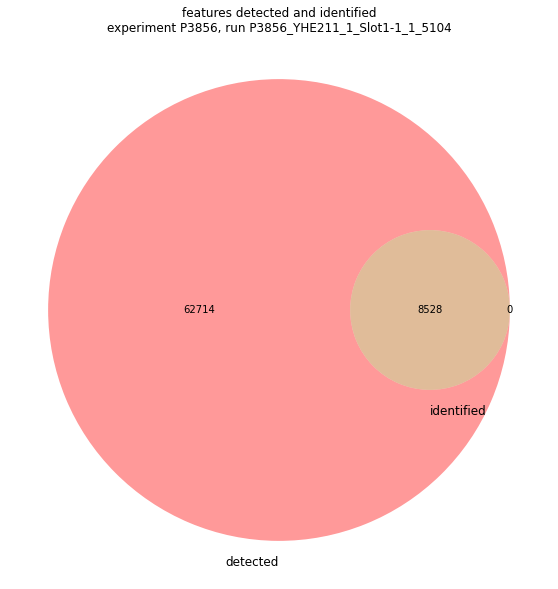

In [71]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('features detected and identified\nexperiment {}, run {}'.format(experiment_name, run_name))

venn2([sets_d['detected'],sets_d['identified']], ('detected','identified'))

plt.show()

#### build the training set

In [15]:
# features detected but not identified
features_not_identified = sets_d['detected'] - sets_d['identified']
features_identified = sets_d['identified']

In [16]:
len(features_not_identified), len(features_identified)

(61878, 8671)

In [17]:
features_not_identified_df = features_df[features_df.feature_id.isin(features_not_identified)]
features_identified_df = features_df[features_df.feature_id.isin(features_identified)]

In [18]:
SAMPLE_SIZE = 8500

In [19]:
features_not_identified_df = features_not_identified_df.sample(n=SAMPLE_SIZE)
features_not_identified_df['category'] = 0

features_identified_df = features_identified_df.sample(n=SAMPLE_SIZE)
features_identified_df['category'] = 1

In [20]:
combined_df = pd.concat([features_not_identified_df, features_identified_df], axis=0, sort=False, ignore_index=True)

In [21]:
combined_df.isna().sum()

mono_mz_lower                               0
mono_mz_upper                               0
scan_apex                                   0
scan_lower                                  0
scan_upper                                  0
rt_apex                                     0
rt_lower                                    0
rt_upper                                    0
intensity_without_saturation_correction     0
intensity_with_saturation_correction        0
mono_intensity_adjustment_outcome           0
mono_mz                                     0
isotopic_peaks                              0
coelution_coefficient                      36
mobility_coefficient                       62
scan_df                                     0
rt_df                                       0
monoisotopic_mz                             0
charge                                      0
monoisotopic_mass                           0
feature_intensity                           0
envelope                          

In [22]:
combined_df.fillna(0, inplace=True)

In [23]:
feature_ids_l = combined_df.feature_id.tolist()

In [24]:
train_proportion = 0.8
val_proportion = 0.1

In [25]:
train_n = round(len(feature_ids_l) * train_proportion)
val_n = round(len(feature_ids_l) * val_proportion)

In [26]:
train_set = random.sample(feature_ids_l, train_n)
val_test_set = list(set(feature_ids_l) - set(train_set))
val_set = random.sample(val_test_set, val_n)
test_set = list(set(val_test_set) - set(val_set))

In [27]:
train_df = combined_df[combined_df.feature_id.isin(train_set)]
valid_df = combined_df[combined_df.feature_id.isin(val_set)]
test_df = combined_df[combined_df.feature_id.isin(test_set)]

In [37]:
train_df.to_pickle('{}/train_df.pkl'.format(expanduser('~')))
valid_df.to_pickle('{}/valid_df.pkl'.format(expanduser('~')))
test_df.to_pickle('{}/test_df.pkl'.format(expanduser('~')))

In [38]:
print('train: {} ({}%), validation: {} ({}%), test: {} ({}%)'.format(len(train_df), round(len(train_df)/len(combined_df)*100), len(test_df), round(len(test_df)/len(combined_df)*100), len(valid_df), round(len(valid_df)/len(combined_df)*100)))


train: 13600 (80%), validation: 1700 (10%), test: 1700 (10%)


In [39]:
input_names = ['deconvolution_score','coelution_coefficient','mobility_coefficient','isotope_count']

In [40]:
X_train = train_df[input_names].to_numpy()
y_train = train_df[['category']].to_numpy()[:,0]

In [41]:
X_valid = valid_df[input_names].to_numpy()
y_valid = valid_df[['category']].to_numpy()[:,0]

In [42]:
X_test = test_df[input_names].to_numpy()
y_test = test_df[['category']].to_numpy()[:,0]

In [43]:
# define the keras model
model = Sequential()
model.add(BatchNormalization(input_shape=(4,)))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [44]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 4)                 16        
_________________________________________________________________
dense_4 (Dense)              (None, 200)               1000      
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 200)               800       
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 200)              

In [47]:
# for visualisation
tf.keras.models.save_model(model, "{}/model.h5".format(expanduser('~')))

In [48]:
# fit the keras model on the dataset
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_valid, y_valid),
                    epochs=4000, 
                    batch_size=512,
                    verbose=0)

best validation loss: 0.3377
best validation accuracy: 0.8671


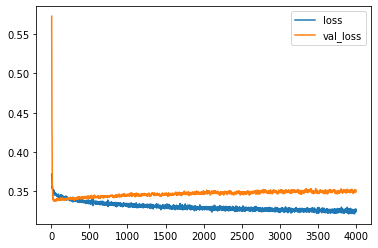

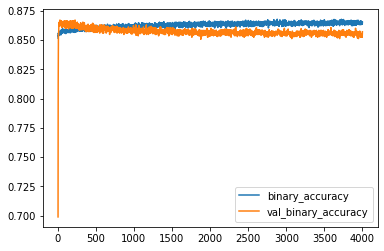

In [49]:
history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()
print(("best validation loss: {:0.4f}"+"\nbest validation accuracy: {:0.4f}").format(history_df['val_loss'].min(), history_df['val_binary_accuracy'].max()))

#### evaluate the model on the test data

In [50]:
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

14/14 [==============================] - 0s 2ms/step - loss: 0.3480 - binary_accuracy: 0.8647
test loss, test acc: [0.3480348587036133, 0.8647058606147766]


#### save the model

In [53]:
model.save("{}/feature_classifier".format(expanduser('~')))

INFO:tensorflow:Assets written to: feature_classifier/assets


#### load the model

In [4]:
MODEL_DIR = '{}/feature_classifier'.format(expanduser('~'))

In [5]:
reconstructed_model = keras.models.load_model(MODEL_DIR)

#### use the model to classify the 3DID features

In [6]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)
FEATURES_3DID_DIR = '{}/features-3did'.format(EXPERIMENT_DIR)
FEATURES_3DID_FILE = '{}/exp-{}-run-{}-features-3did.pkl'.format(FEATURES_3DID_DIR, experiment_name, run_name)
FEATURES_3DID_IDENT_FILE = '{}/exp-{}-run-{}-features-3did-ident.pkl'.format(FEATURES_3DID_DIR, experiment_name, run_name)

In [7]:
# load the features detected by 3DID
with open(FEATURES_3DID_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_3did_df = d['features_df']
# features_3did_metadata = d['metadata']

In [8]:
features_3did_metadata = d['metadata']

In [9]:
features_3did_df.fillna(0, inplace=True)

In [12]:
predictions = reconstructed_model.predict(features_3did_df[input_names].to_numpy())

In [13]:
features_3did_df['prediction'] = predictions

In [14]:
features_3did_df.sample(n=3)

,mono_mz_lower,mono_mz_upper,scan_apex,scan_lower,scan_upper,rt_apex,rt_lower,rt_upper,intensity_without_saturation_correction,intensity_with_saturation_correction,...,deconvolution_score,feature_region_3d_extent,voxel_id,voxel_metadata_d,scan_df,scan_r_squared,rt_df,rt_r_squared,feature_id,prediction
45220,776.319754,776.369206,559.0,549.0,585.0,1692.785661,1678.494148,1707.073396,1304,1304,...,515.160641,"{'mz_lower': 776.2380436456243, 'mz_upper': 77...",340005243,"{'mz_lower': 776.7877923893429, 'mz_upper': 77...","[{'scan': 531, 'intensity': 527, 'filtered_int...",0.999539,"[{'frame_id': 14827, 'retention_time_secs': 16...",0.953860,45220,0.802911
152366,953.930712,953.991479,374.0,334.0,384.0,1882.268527,1867.981328,1896.559609,1553,1553,...,1027.960072,"{'mz_lower': 953.8259535462913, 'mz_upper': 95...",430006186,"{'mz_lower': 954.3757022900099, 'mz_upper': 95...","[{'scan': 295, 'intensity': 306, 'filtered_int...",0.996758,"[{'frame_id': 16622, 'retention_time_secs': 18...",0.910054,152366,0.858350
31764,734.016831,734.063588,683.0,667.0,709.0,1987.585658,1977.529440,2001.343945,708,708,...,156.694562,"{'mz_lower': 733.7250878961327, 'mz_upper': 73...",320008345,"{'mz_lower': 734.2748366398513, 'mz_upper': 73...","[{'scan': 649, 'intensity': 1470, 'filtered_in...",0.979071,"[{'frame_id': 17567, 'retention_time_secs': 19...",0.996237,31764,0.864608


In [15]:
features_3did_df['identification_predicted'] = features_3did_df.apply(lambda row: row.prediction >= 0.5, axis=1)

In [16]:
features_3did_df.sample(n=3)

,mono_mz_lower,mono_mz_upper,scan_apex,scan_lower,scan_upper,rt_apex,rt_lower,rt_upper,intensity_without_saturation_correction,intensity_with_saturation_correction,...,feature_region_3d_extent,voxel_id,voxel_metadata_d,scan_df,scan_r_squared,rt_df,rt_r_squared,feature_id,prediction,identification_predicted
219083,1138.855070,1138.927616,130.0,120.0,204.0,2116.712208,2102.423976,2132.067029,542,542,...,"{'mz_lower': 1138.44991972546, 'mz_upper': 114...",520000841,"{'mz_lower': 1138.9996684691785, 'mz_upper': 1...","[{'scan': 128, 'intensity': 24182, 'filtered_i...",0.994955,"[{'frame_id': 18842, 'retention_time_secs': 20...",0.972795,219083,0.340276,False
122841,895.433907,895.490947,414.0,408.0,424.0,1788.586257,1774.294668,1804.469322,1134,1134,...,"{'mz_lower': 894.32499693029, 'mz_upper': 897....",400017224,"{'mz_lower': 894.8747456740086, 'mz_upper': 89...","[{'scan': 377, 'intensity': 420, 'filtered_int...",0.000000,"[{'frame_id': 15722, 'retention_time_secs': 17...",0.962020,122841,0.889956,True
221279,1133.961992,1134.034226,94.0,49.0,104.0,1974.882557,1957.949529,1988.114939,1040,1040,...,"{'mz_lower': 1132.4197689716912, 'mz_upper': 1...",520005039,"{'mz_lower': 1132.9695177154097, 'mz_upper': 1...","[{'scan': 41, 'intensity': 83, 'filtered_inten...",0.974715,"[{'frame_id': 17472, 'retention_time_secs': 19...",0.890676,221279,0.683544,True


In [17]:
sets_d = {'detected':set(), 'identification predicted':set()}

In [18]:
sets_d['detected'] = set(features_3did_df.feature_id.tolist())
sets_d['identification predicted'] = set(features_3did_df[(features_3did_df.identification_predicted == True)].feature_id.tolist())

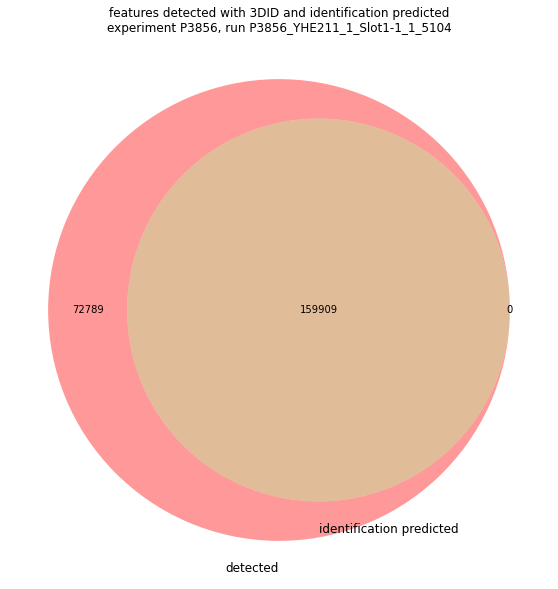

In [19]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('features detected with 3DID and identification predicted\nexperiment {}, run {}'.format(experiment_name, run_name))

venn2([sets_d['detected'],sets_d['identification predicted']], ('detected','identification predicted'))

plt.show()

In [20]:
# filter out the features unlikely to be identified
features_3did_df = features_3did_df[(features_3did_df.identification_predicted == True)]

In [21]:
info = []
info.append(('experiment_base_dir', EXPERIMENT_DIR))
info.append(('experiment_name', experiment_name))
info.append(('run_name', run_name))
info.append(('model', MODEL_DIR))
info.append(('processor', 'paper 4 - feature classifier.ipynb'))
info.append(('processed', time.ctime()))

In [22]:
print('writing {} features to {}'.format(len(features_3did_df), FEATURES_3DID_IDENT_FILE))
content_d = {'features_df':features_3did_df, 'metadata':info}
with open(FEATURES_3DID_IDENT_FILE, 'wb') as handle:
    pickle.dump(content_d, handle)

writing 159909 features to /media/big-ssd/experiments/P3856/features-3did/exp-P3856-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did-ident.pkl
